In [1]:
from nepse import AsyncNepse 
import asyncio
import pandas as pd
from datetime import datetime, timedelta
import os
import glob


In [2]:
nepse = AsyncNepse()
nepse.setTLSVerification(False)  # Temporary, until NEPSE sorts its SSL certificate problem

In [3]:
df=pd.read_json(r'files\2025\2025-01-20.json')
# df['id']=df['marketDepth'][0].get('buyMarketDepthList')[0].get('stockId')
df

,timestamp,data
0,2025-01-20 11:00:04.061386,{'USHL': 'error code Expecting value: line 1 c...
1,2025-01-20 11:25:34.498529,"{'USHL': {'totalBuyQty': 7562, 'marketDepth': ..."
2,2025-01-20 11:57:51.929936,"{'USHL': {'totalBuyQty': 13603, 'marketDepth':..."
3,2025-01-20 12:29:32.839163,"{'USHL': {'totalBuyQty': 7561, 'marketDepth': ..."
4,2025-01-20 13:03:41.479863,"{'USHL': {'totalBuyQty': 7932, 'marketDepth': ..."
5,2025-01-20 13:25:26.547882,"{'USHL': {'totalBuyQty': 8318, 'marketDepth': ..."
6,2025-01-20 14:04:41.237962,"{'USHL': {'totalBuyQty': 7918, 'marketDepth': ..."
7,2025-01-20 14:27:26.180305,"{'USHL': {'totalBuyQty': 7828, 'marketDepth': ..."
8,2025-01-20 14:39:41.994745,"{'USHL': {'totalBuyQty': 8088, 'marketDepth': ..."


In [4]:
df_combined = pd.DataFrame()
for i in df.index:
    df1 = pd.DataFrame.from_dict(df['data'][i]).T[['totalBuyQty', 'totalSellQty']]
    df1['timestamp'] = df['timestamp'][i]
    df1.reset_index(inplace=True)
    if df_combined.empty:
        df_combined = df1
    else:
        df_combined = pd.concat([df_combined, df1])

In [5]:
df_combined=pd.merge(df_combined, pd.DataFrame.from_dict(await nepse.getCompanyList())[['symbol', 'sectorName']], left_on='index',right_on='symbol', how='left')


In [6]:
df_combined.to_clipboard()

In [9]:
df_combined

,index,totalBuyQty,totalSellQty,timestamp
0,USHL,2851,2506,2025-01-13 11:09:37.774299
1,ACLBSL,10,402,2025-01-13 11:09:37.774299
2,ACLBSLP,0,0,2025-01-13 11:09:37.774299
3,ANLB,0,3985,2025-01-13 11:09:37.774299
4,ANLBP,0,0,2025-01-13 11:09:37.774299
...,...,...,...,...
476,VLBS,4002,1648,2025-01-13 14:38:42.115729
477,VLBSPO,0,0,2025-01-13 14:38:42.115729
478,VLUCL,20149,14664,2025-01-13 14:38:42.115729
479,WNLB,2441,5700,2025-01-13 14:38:42.115729


In [3]:

# Initialize an empty DataFrame
df_combined = pd.DataFrame()

# Loop through each JSON file in the directory
for file in glob.glob(r'files\2025\*.json'):
    df_temp = pd.read_json(file)
    for i in range(len(df_temp['data'])):
        df1 = pd.DataFrame.from_dict(df_temp['data'][i]).T[['totalBuyQty', 'totalSellQty']]
        df1['timestamp'] = df_temp['timestamp'][i]
        df1.reset_index(inplace=True)
        if df_combined.empty:
            df_combined = df1
        else:
            df_combined = pd.concat([df_combined, df1])

# Assign the combined DataFrame to df2
df3 = df_combined

In [4]:
df3[df3['index']=='SNLI']

,index,totalBuyQty,totalSellQty,timestamp
434,SNLI,2976,950,2025-01-01 11:08:38.469359
434,SNLI,15393,1889,2025-01-01 11:25:13.886984
434,SNLI,117821,3573,2025-01-01 12:16:44.498276
434,SNLI,117861,3742,2025-01-01 12:31:21.399839
434,SNLI,117673,4375,2025-01-01 12:55:36.500189
434,SNLI,120872,6212,2025-01-01 13:17:21.609275
434,SNLI,120879,6564,2025-01-01 14:02:49.728837
434,SNLI,119792,6469,2025-01-01 14:29:05.596801
434,SNLI,119009,6790,2025-01-01 14:37:13.072795
434,SNLI,2370,411,2025-01-02 11:08:40.158032


<Axes: xlabel='timestamp'>

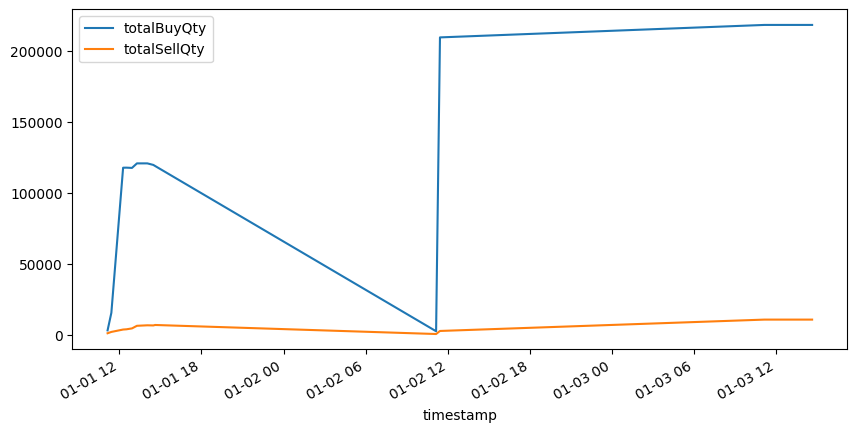

In [60]:
df3[df3['index']=='SNLI'].plot(x='timestamp', y=['totalBuyQty', 'totalSellQty'], figsize=(10, 5))

In [27]:
for i in range(len(df['data'])):
    df1=pd.DataFrame.from_dict(df['data'][i]).T[['totalBuyQty','totalSellQty']]
    df1['timestamp']=df['timestamp'][i]
    df1.reset_index(inplace=True)
    if i==0:
        df2=df1
    else:
        df2=pd.concat([df2,df1])

In [37]:
df2[df2['index']=='UPCL']

,index,totalBuyQty,totalSellQty,timestamp
466,UPCL,8210,700,2025-01-01 11:08:38.469359
466,UPCL,26211,1160,2025-01-01 11:25:13.886984
466,UPCL,39489,8230,2025-01-01 12:16:44.498276
466,UPCL,41212,8765,2025-01-01 12:31:21.399839
466,UPCL,45140,11354,2025-01-01 12:55:36.500189
466,UPCL,45673,12282,2025-01-01 13:17:21.609275
466,UPCL,46773,17285,2025-01-01 14:02:49.728837
466,UPCL,49913,14801,2025-01-01 14:29:05.596801
466,UPCL,49262,15555,2025-01-01 14:37:13.072795


In [42]:
def get_ohlc_data(df, script,qty_type):
    # Filter the dataframe for the given script
    script_data = df[df['index'] == script]

    # Ensure the data is sorted by timestamp
    script_data = script_data.sort_values(by='timestamp')

    # Get the OHLC data
    ohlc_data = {
        'open': script_data.iloc[0][qty_type],
        'high': script_data[qty_type].max(),
        'low': script_data[qty_type].min(),
        'close': script_data.iloc[-1][qty_type]
    }
    return ohlc_data

# Example usage
ohlc_data = get_ohlc_data(df2, 'UPCL','totalSellQty')
print(ohlc_data)

{'open': 700, 'high': 17285, 'low': 700, 'close': 15555}


<Axes: xlabel='timestamp'>

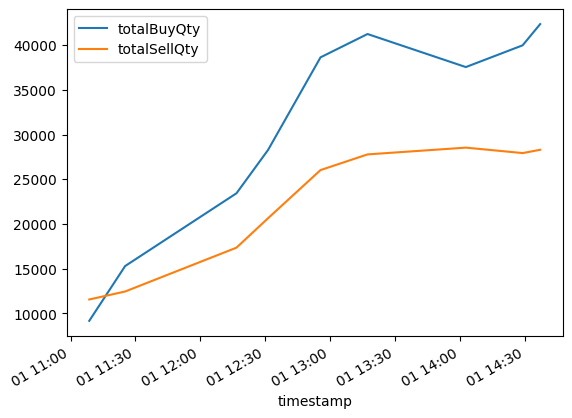

In [43]:
df2[df2['index']=='SHIVM'].plot(x='timestamp',y=['totalBuyQty','totalSellQty'])

In [22]:
df2[df2['symbol']=='SMHL']

KeyError: 'symbol'

In [21]:

pd.DataFrame.from_dict(await nepse.getCompanyList()).to_clipboard()

In [20]:
await nepse.getMarketStatus()

{'isOpen': 'CLOSE', 'asOf': '2024-12-26T15:00:00', 'id': 80}

In [9]:
pd.DataFrame.from_dict(df['data'][0])

ValueError: If using all scalar values, you must pass an index

In [3]:
datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

'2024-12-26_18-52-50'

In [6]:
from datetime import timedelta

adjusted_time = datetime.now() - timedelta(hours=5, minutes=45)
adjusted_time.strftime("%Y-%m-%d_%H-%M-%S")

'2024-12-26_13-39-34'

In [21]:
def get_id(dep_dict):
    if isinstance(dep_dict, dict) and 'buyMarketDepthList' in dep_dict:
        try:
            return dep_dict.get('buyMarketDepthList')[0].get('stockId')
        except (IndexError, AttributeError):
            return None  # Return None if the structure isn't as expected
    return None  # Return None for non-dictionaries or invalid inputs

In [38]:
pd.DataFrame.from_dict(await nepse.getCompanyList()).to_clipboard()

In [ ]:
adjusted_time = datetime.now() - pd.Timedelta(hours=5, minutes=45)
adjusted_time.strftime("%Y-%m-%d_%H-%M-%S")

In [2]:
nepse = AsyncNepse()
nepse.setTLSVerification(False)  # Temporary, until NEPSE sorts its SSL certificate problem

async def fetch_company_details():
    # Fetch the list of companies
    company_list = await nepse.getCompanyList()

    # Fetch details for each company concurrently
    tasks = [
        nepse.getCompanyDetails(company['symbol']) 
        for company in company_list 
        if company['status'] == 'A'
    ]

    company_details = await asyncio.gather(*tasks)

    # Combine company and details
    result = []
    for company, details in zip(company_list, company_details):
        # If details is a list, handle it appropriately
        if isinstance(details, list):
            # Add details as a key-value pair
            result.append({**company, "details": details})
        elif isinstance(details, dict):
            # Merge dictionaries directly
            result.append({**company, **details})
        else:
            # Handle unexpected formats (optional)
            result.append({**company, "details": str(details)})

    return result

In [28]:
df=pd.DataFrame.from_dict(await nepse.getSecurityList())

NameError: name 'nepse' is not defined

In [5]:
async def main():
    results = await fetch_company_details()

    # Ensure the "files/" directory exists
    os.makedirs("files", exist_ok=True)

    # Generate filename with timestamp
    now = datetime.now()
    filename = now.strftime("%Y-%m-%d_%H-%M-%S")
    pd.DataFrame.from_dict(results).to_excel(f"files/{filename}.xlsx", index=False)

# Execute the main function
# asyncio.run(main()) ## This is not working in Jupyter Notebook, but in py file it must be the function
await main()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py:106: RuntimeWarning: coroutine 'main' was never awaited
  if proto not in {0, socket.IPPROTO_TCP, socket.IPPROTO_UDP} or \


In [105]:
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Candlestick(x=demand_ohlc.reset_index()['a'],
#                     open=demand_ohlc['open'],
#                     high=demand_ohlc['high'],
#                     low=demand_ohlc['low'],
#                     close=demand_ohlc['close']))
# fig.show()